# Spectral Methods and the PSD

##### Sydney Smith 2018, Torben Noto 2015

Although there are many ways you can process a digital signal, one of the most useful is the power spectral density (PSD). The PSD allows you to vizualize what frequencies are present in a signal. In other words, the PSD lets you look at the signal in the **frequency domain**. Discovering which frequencies are present allows you to investigate the signal beyond the time domain and can be very useful for large-scale data analysis. Let's go over how to generate one.

The purpose of this tutorial is to:
1. Define the PSD
2. Introduce the Fourier Transform
3. Demonstrate how the Fourier transform is used to analyze a complex signal
4. Generate a PSD from real electrophysiological data
5. Identify features in the PSD that are important for data analysis

### Default Imports

First, let's import some python libraries that contain the functions we need to do this tutorial. I've also included some figure formatting to make sure our plots are easy to read.

In [3]:
%matplotlib inline

import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.signal

figure = {'figsize': (16,6)}
plt.rc('figure', **figure)

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 15}
plt.rc('font', **font)

## 1. Analyzing data in the frequency domain: The PSD

Electrophysiological signals are time series composed of many different frequencies. Each of these frequencies contains some amount of voltage power. In the analysis of electrophysiological signals, it can be useful to determine what frequencies are present and how much power they have. These measurements of frequency and power can be correlated to a variety of factors associated with brain function, allowing us to learn even more about the brain.

<img src="./img/examplePSD.png" height="400" width="400">

Pictured above is an example of a PSD calculated from the time series recording from the hippocampus of a rat.

The power spectral density (PSD) is a graphical representation of the frequencies present in a signal that allows us to vizualize how much power is present in each frequency. The plot of **power vs. frequency** is known as a spectrum. PSDs aren't limited to the analysis of neural signals; they can be used to vizualize any kind of time series data (eg. sounds, financial trends, earthquakes, etc.). 

In the next sections, we'll delve a little deeper into how the PSD is generated and how to read it. 

## 2. The Fourier Transform

The mathmatical technique that allows us to calculate the PSD is called the Fourier Transform. **The Fourier Transform measures the amplitude of every frequency in a signal**. The math that it takes to do this is pretty brilliant and challenging but we don't have to get too deep into it.

Here's an analogy: Imagine you play a chord on a piano. If you ran a Fourier transform on the sound signal, you could see how hard you pressed each of the keys. However, in the brain, there are a lot of frequencies present in the same signal and they aren't as simple as a chord with 3 discrete notes. 

For now, let's try something simpler to investigate what a Fourier Transform can tell us about a signal. Let's start by running it on a complex sinusoid.

## 3. The FFT of a complex sinusoid

In this section, I will generate a complex sinusoid that is composed of 2 frequencies: 7 Hz and 130 Hz. Then, I'll run the Fourier Transform, abbreviated here as "FFT."

#### Generating the a complex sinusoid

To make the following signal, I added 2 sin waves together. There is a slower wave (7 Hz) with a large amplitude and a fast wave (130 Hz) with a smaller amplitude. Make sure that you pick these out.

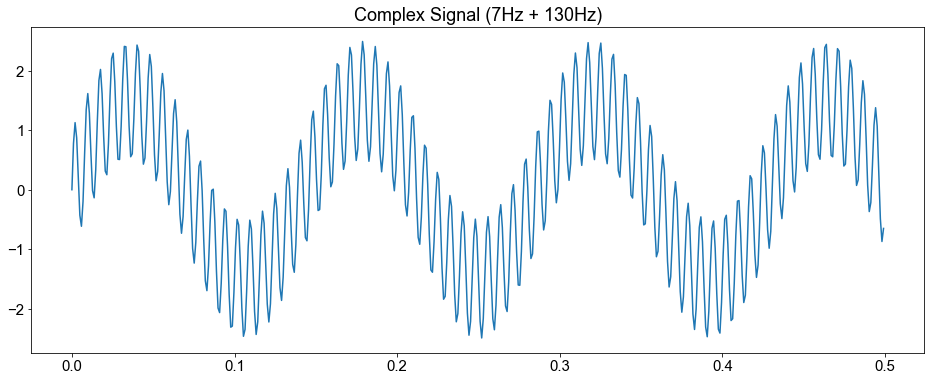

In [4]:
f = 1024 #sampling frequency
dur = 10 #10 seconds of signal
freq = 7 #7 Hz signal
freq2 = 130 #130 Hz signal
t = np.arange(0, dur, 1/f) #times for d
sig1 = np.sin(2 * np.pi * freq * t) #10 Hz wavelength
sig1 = 1.5*sig1; #increase the power of signal 1
sig2 = np.sin(2 * np.pi * freq2 * t) #130 Hz wavelength
plt.figure(figsize=(16,6))
plt.title("Complex Signal (7Hz + 130Hz)", size=18)
plt.plot(t[0:512],sig1[0:512]+sig2[0:512]) #plot 0.5 seconds of data

#### Running and Plotting the FFT

Now that we have the complex signal, let's run the FFT and see if it can pick out the 2 component frequencies. We can vizualize the output in a plot of Power vs. Frequency. Recall from the first section that this is called a spectrum.

/Users/sydneysmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


Text(0.5,1,'FFT of a complex signal')

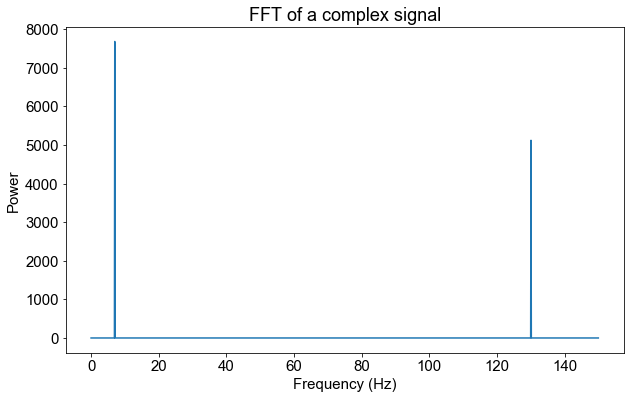

In [5]:
# calculating fourier transform of complex signal
fourier = np.fft.fft(sig1+sig2)

# finding frequency values for the x axis
fx_step_size = f/len(sig1)
nyq = f/2
total_steps = nyq/fx_step_size
fx_bins = np.linspace(0,nyq,total_steps)

# plotting up to 200 Hz
plt.figure(figsize = (10,6))
plt.plot(fx_bins[0:1500],abs(fourier[0:1500]))
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of a complex signal', size=18)

So in this plot we're looking at the power of all of the freqencies present in our signal.

We can clearly see that there is a peak at 7 Hz and a peak at 130 Hz.
We can also see that the 7 Hz peak has a greater amplitude than the one at 130 Hz.

From this we can conclude that the Fourier Transform accurately identified both frequency components in the signal in addition to telling us how much power (amplitude) is present in each of those components.

However, notice that when we do this, we can't see any information about the timing in our signal. When looking at a signal in frequency space, we can't know anything about the **offset of the phases** of these oscillations.

But we still have information about phase. This information is stored as complex numbers that we're not plotting above. It's called a Fourier **transform** because **no information is lost when we apply it**. You can calculate the fourier transform or the inverse fourier transform of a signal over and over again and not lose any information, effectively switching between the frequency and time domains. 

## 4. Generating the PSD of electrophysiological data

Now that we've demonstrated how the FFT can help us look at a signal in the frequency domain, let's apply it to something a little more interesting: electrophysiological data. Specifically, in this section we will use the FFT to generate a PSD of a real ECoG signal. 

#### Load the electrophysiological data (ECoG)

In [6]:
#loading data
path = 'dat/emodat.npy'

data = np.load(path)

#### Returning to sampling rate 
The sampling rate is important for analyzing in the frequency domain because it determines the range of frequencies that can be detected in the signal. If you need to review sampling rate, see [our tutorial](LINK) or, if you want a more in-depth explanation, check out this [interactive guide](https://jackschaedler.github.io/circles-sines-signals/part2.html) from Jack Schaedler.

I'll print the sampling rate for the data we loaded below.

In [7]:
srate = 1017.2533333333334

#resample at 1024 Hz
newsrate = 1024 # new sampling rate
ecog_signal = sp.signal.resample(data, int(np.floor(len(data)*(newsrate/srate))))
srate = newsrate

1017.2533333333334 Hz


The sampling rate for this data is about 1017 Hz. This means we can detect frequencies in the signal up to about 508 Hz. I won't go into detail about why this is, but if you're curious, use the links above to find more information.

#### Plot the data in the time domain

Plotted below is 1 second of neural data. You might observe some up-and-downs and conclude that it is oscillatory, but it's not too insightful otherwise.

Text(0.5,1,'ECoG Signal in the Time Domain')

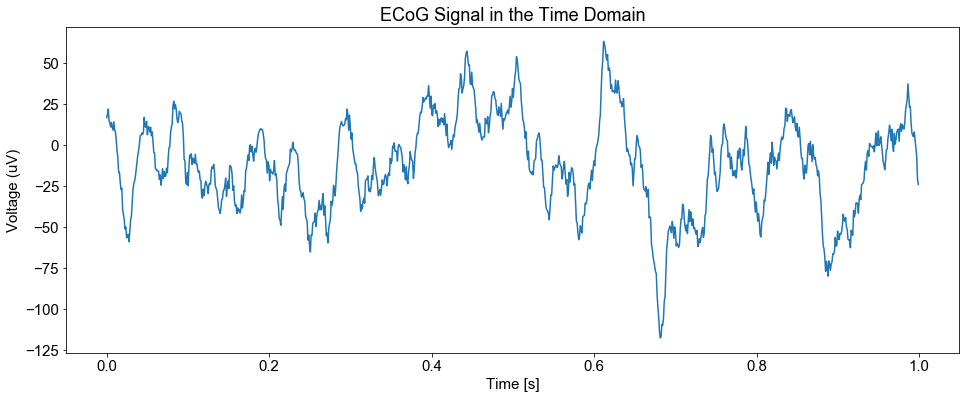

In [8]:
plt.figure(figsize = (16, 6))
plt.plot(np.arange(0, 1024)/1024., data[10000:11024])
plt.ylabel('Voltage (uV)')
plt.xlabel('Time [s]')
plt.title('ECoG Signal in the Time Domain', size=18)

#### Calculate and plot the PSD using the FFT

Now that we've loaded the ECoG signal and we know what it looks like in the time domain, let's run a FFT and plot the output into a PSD.

/Users/sydneysmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


Text(0.5,1,'FFT of ECoG signal')

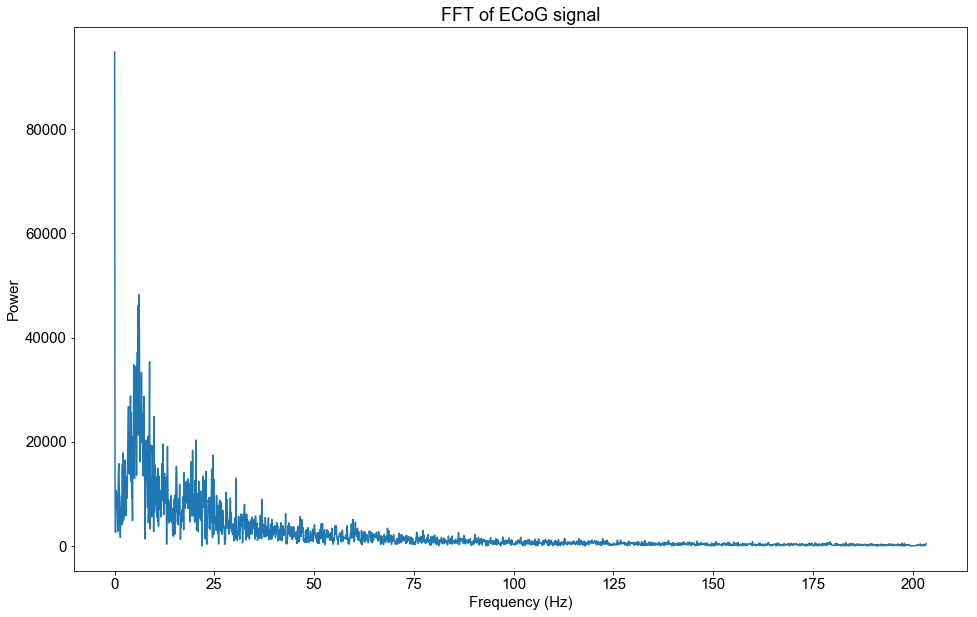

In [9]:
# calculating fourier transform of complex signal
# we're going to take a sample of the data to keep fx bins at a reasonable size.
fourier = np.fft.fft(data[0:10000]) 

# finding frequency values for the x axis
fx_step_size = srate/len(data[0:10000])
nyq = srate/2
total_steps = nyq/fx_step_size
fx_bins = np.linspace(0,nyq,total_steps)

plt.figure(figsize=(16,10))
plt.plot(fx_bins[0:2000],abs(fourier[0:2000])) #any frequencies above 200 Hz are probably noise
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of ECoG signal', size=18)

Tada! Our first PSD! It looks significantly different than the one we just made for the complex signal. This one looks pretty messy and is difficult to interpret because power seems to be decaying exponentially with frequency. So let's try plotting it in log scale. 

Text(0.5,1,'FFT of ECoG signal (log scale)')

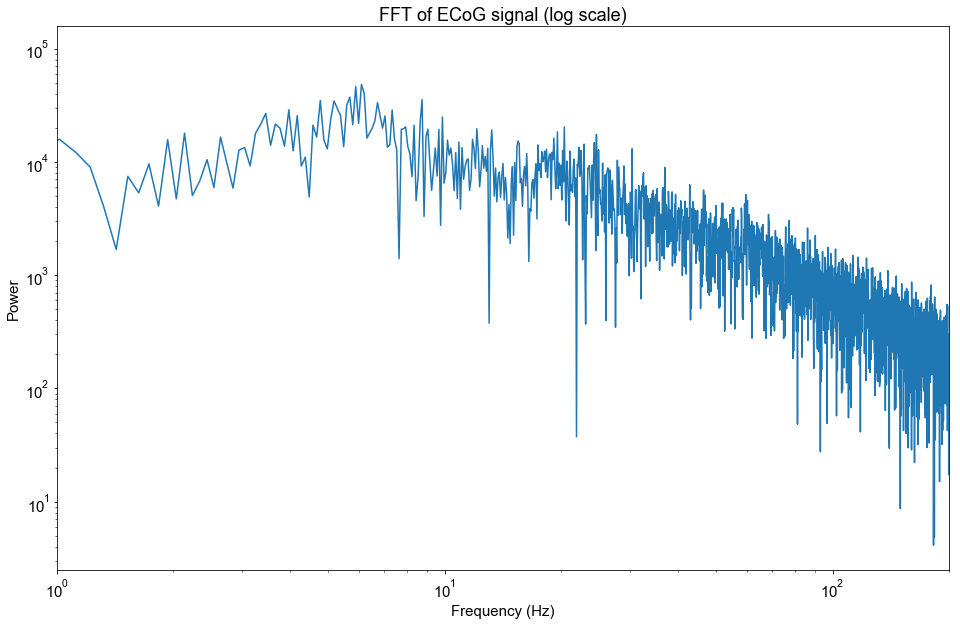

In [10]:
plt.figure(figsize=(16,10))
plt.loglog((fx_bins[0:2000]),(abs(fourier[0:2000]))) #any frequencies above 200 Hz are probably noise
plt.xlim([1,200])
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of ECoG signal (log scale)', size=18)

That looks a little better. We can see that there are many wavelengths that contribute to this signal, a stark comparison to the two-component sinusoid we analyzed earlier. Additionally, notice that it looks like longer wavelengths (slower frequencies) seem to have a larger power than shorter wavelengths (higher frequencies).

##### Slope of the PSD and 1/f power law
While messy, the data in this plot show an interesting relationship. The data form a rough line that proceeds downward diagonally from the upper left corner to the lower right corner of the plot. Actually, the equation for this line is P = 1/f. This is a very special mathmatical ratio called a power law distribution or pink noise. 1/f relationships show up everywhere in nature in spooky ways. Magnitudes of earthquakes, fluctuations in the stock market, sizes of craters on the moon, and even the power spectrum of popular music all have power law distributions. Here we can see the same relationship in neural signals. We'll look at the 1/f relationship in more detail in a later tutorial but for now, back to the PSD!

#### Welch's PSD
There's a way to smooth out our FFT without losing too much information. The most common way of doing this is by using **Welch's method**.
Basically, we calculate the FFT of a signal across a few sliding windows. Then we calculate the mean PSD from all the sliding windows. Notice that this PSD is also plotted on a log scale.

/Users/sydneysmith/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Text(0.5,1,"Welch's PSD of ECoG signal")

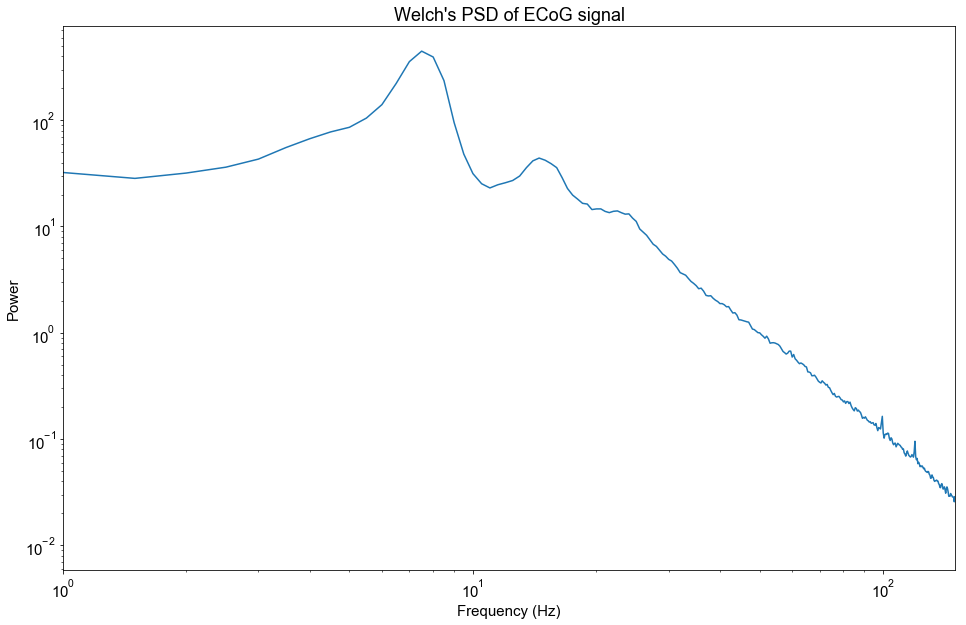

In [11]:
#Calculate the Welch's PSD of the data
f,pspec = sp.signal.welch(data, fs=srate, window='hanning', nperseg=2*srate, noverlap=srate/2,
                          nfft=None, detrend='linear', return_onesided=True, scaling='density')

plt.figure(figsize=(16,10))
plt.loglog(f[0:200*2],pspec[0:200*2])#Any frequencies with >200 Hz are going to be noise in ECoG data.
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.xlim([1, 150])
plt.title("Welch's PSD of ECoG signal", size=18)

Now the signal is much cleaner and easier to interpret. We can start to notice some interesting features of the PSD including a much clearer 1/f slope and some interesting "bumps", or peaks, in the spectrum around 8, 14, and 25 Hz. We'll talk about why these peaks are significant in the next section.

## 5. Analyzing the PSD: Important features and insights

The PSD is an extremely useful tool when it comes to analyzing neural data. Different features of the PSD can be correlated with certain brain regions, tasks and behaviors, age, and even mental illnesses. Two of these features are oscillations and aperiodic slope. 

#### Oscillations

Neural oscillations are prominent, consistent fluctuations in electrophysiological signals that are present throughout the brain. Although there is still much more to understand about them, they have been associated with the brain's vital functions, including interregional communication, perceptual performance, and the production of motor movements. 

Identifying oscillations is vital to studying them and their purpose in the brain. Luckily, oscillations can be picked out by analyzing the PSD. Remember the peaks we talked about in the previous section? Although not universally accepted, the majority of the electrophysiological community has agreed that a *peak in the PSD at a certain frequency indicates the presence of an oscillation at that frequency* ([He, et al. 2010](https://doi.org/10.1016/j.neuron.2010.04.020)). 

For example, the Welch's PSD from the previous section most likely has oscillations at 8, 14, and 25 Hz. Oscillations in these frequencies are associated with bands of activity, known as theta, alpha, and beta. These frequency bands have been studied since the 1950's but we're still discovering lots of new things about them. 

#### Aperiodic Slope

The relationship between power and frequency is another important property of PSDs. In the literature this property is referred to as aperiodic slope. The PSD tends to have a slope of roughly 1/f, following a **power law distribution**. However, when you look at lots of PSDs, you start to see variations in the slope of the spectrum. These variations in slope can be correlated with factors like age or mental illness, even task performance. Although the slope of electrophysiological PSDs was recognized decades ago, what slope is and what is producing it is still being investigated. 

If you'd like to know more about what the Voytek lab thinks slope could be, check out [Gao, et al. 2017](https://doi.org/10.1016/j.neuroimage.2017.06.078).